Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Kats Trend Detection

🌺 <b>Rather than identifying change points, trend detection identifies windows of gradual and prolonged change.</b>

* Kats General
  * `TimeSeriesData` params and methods: https://facebookresearch.github.io/Kats/api/kats.consts.html#kats.consts.TimeSeriesData
* Kats Detection
  * Kats detection official tutorial: https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_202_detection.ipynb
  * Modified Kats library used here: https://github.com/hanhanwu/Kats
* Trend Detection
  * About M-K (Mann Kendall) Test: https://www.statisticshowto.com/mann-kendall-trend-test/
    * It requires the input ts data has no seasonality
  * About Seasonal M-K Test: https://www.statisticshowto.com/seasonal-kendall-test/
    * It devides the ts data into m seasons, and apply M-K test for each season
  * Formulas of M-K test and Seasonal M-K test: https://www.epa.gov/sites/default/files/2016-05/documents/tech_notes_6_dec2013_trend.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from imp import reload
from datetime import datetime, timedelta
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
from kats.detectors.trend_mk import MKDetector
from Kats.kats.detectors.trend_smk import SMKDetector  # this is self-implemented detector

In [2]:
ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df_train = ts_df.iloc[ts_df.index < '2015-03-01']
print(ts_df_train.shape)

ts_df.head()

(942, 1)
(789, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [3]:
def plot_ts(ts, label, title):
    plt.figure(figsize=(20,3))
    fig = plt.plot(ts, label=label, color='blue')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

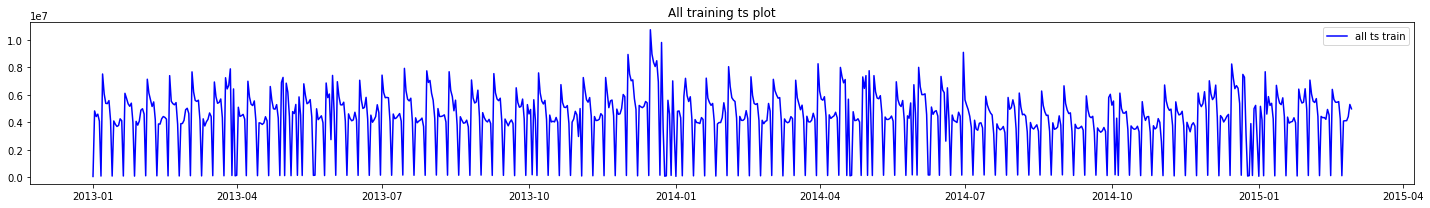

In [4]:
plot_ts(ts_df_train, label='all ts train', title='All training ts plot')

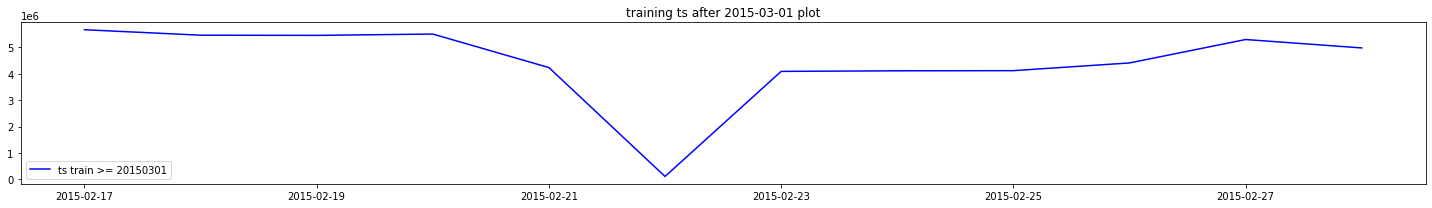

In [5]:
sub_ts = ts_df_train.iloc[ts_df_train.index >= '2015-02-17']
plot_ts(sub_ts, label='ts train >= 20150301', title='training ts after 2015-03-01 plot')

In [6]:
# Covert to Kats required TimeSeriesData input

kats_ts_all = TimeSeriesData(ts_df_train.reset_index().rename(index=str, columns={'Date': 'time'}))
print(len(kats_ts_all))

kats_ts_sub = TimeSeriesData(sub_ts.reset_index().rename(index=str, columns={'Date': 'time'}))
print(len(kats_ts_sub))

789
12


## M-K (Mann Kendall) Test

* Kats M-K detector: https://facebookresearch.github.io/Kats/api/kats.detectors.trend_mk.html
  * It requires the data input has no seasonality
  * But uses param `freq` to indicate the seasonality (weekly/monthly/yearly), so that if there's such seasonality in the ts, it can apply rolling average with the relevant frequency (weekly/monthly/yearly) to smooth the ts input
* Kats used the `original_test()` from `pymannkendall` library: https://github.com/facebookresearch/Kats/blob/main/kats/detectors/trend_mk.py#L276, which is the original M-K test
  * Kats only uses the `original_test` and `multivariate_test` from `pymannkendall` library (https://pypi.org/project/pymannkendall/)

In [14]:
def trend_mk_detect(ts, direction='both', window_size=20, freq=None, threshold=0.8, print_info='Trend Detection'):
    print(print_info)
    ts_detector = MKDetector(data=ts, threshold=threshold)
    detected_trend = ts_detector.detector(direction=direction, window_size=window_size, freq=freq)
    ts_detector.plot(detected_trend)
    plt.show()
    
    return detected_trend

### ts all

* Using all the training ts as the input

Down Trend of ts all


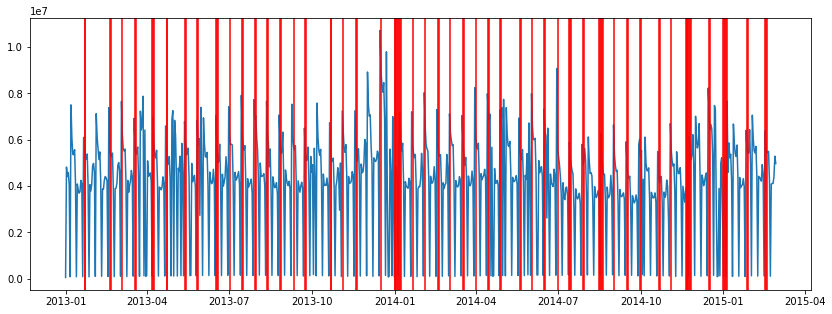

Number of detected points is: 100
MKChangePoint(start_time: 2013-01-22 00:00:00, end_time: 2013-01-22 00:00:00, confidence: 0.9996533806488654, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -0.9111111111111111)


In [8]:
ts_all_down_points = trend_mk_detect(kats_ts_all, direction='down', window_size=10, freq='weekly',
                threshold=0.8, print_info='Down Trend of ts all')

print(f'Number of detected points is: {len(ts_all_down_points)}')
print(ts_all_down_points[0])

Up Trend of ts all


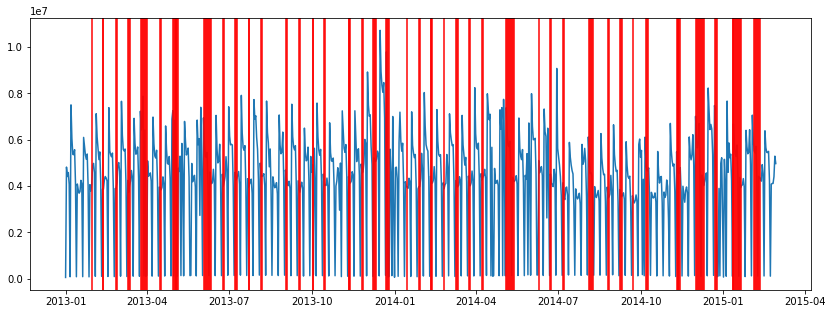

Number of detected points is: 138
MKChangePoint(start_time: 2013-02-27 00:00:00, end_time: 2013-02-27 00:00:00, confidence: 0.9987178162581947, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: increasing Tau: 0.8222222222222222)


In [9]:
ts_all_up_points = trend_mk_detect(kats_ts_all, direction='up', window_size=10, freq='weekly',
                threshold=0.8, print_info='Up Trend of ts all')

print(f'Number of detected points is: {len(ts_all_up_points)}')
print(ts_all_up_points[4])

Up Trend of ts all (no seasonality smoothing)


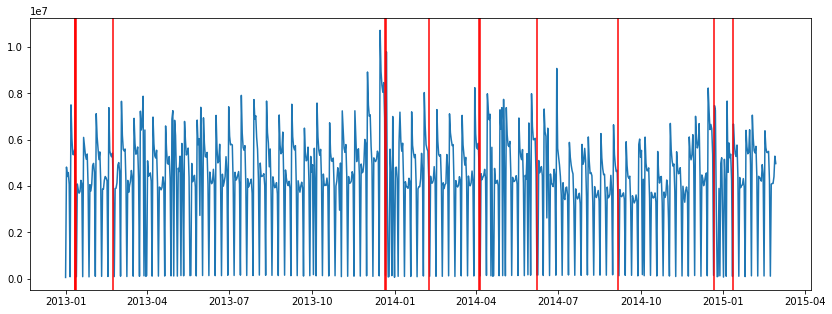

Number of detected points is: 13
MKChangePoint(start_time: 2013-01-11 00:00:00, end_time: 2013-01-11 00:00:00, confidence: 0.9996533806488654, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: increasing Tau: 0.9111111111111111)


In [10]:
ts_all_up_points_no_smoothing = trend_mk_detect(kats_ts_all, direction='up', window_size=10,
                threshold=0.8, print_info='Up Trend of ts all (no seasonality smoothing)')

print(f'Number of detected points is: {len(ts_all_up_points_no_smoothing)}')
print(ts_all_up_points_no_smoothing[0])

Up Trend of ts all (larger look back window)


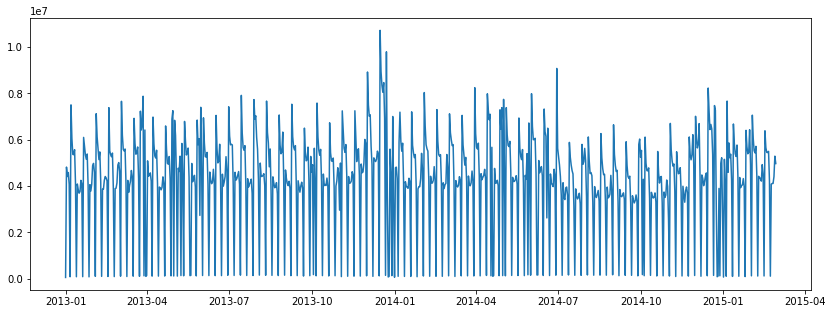

Number of detected points is: 0


In [11]:
ts_all_up_points_larger_window = trend_mk_detect(kats_ts_all, direction='up', window_size=30, freq='weekly',
                threshold=0.8, print_info='Up Trend of ts all (larger look back window)')

print(f'Number of detected points is: {len(ts_all_up_points_larger_window)}')

### ts subset

* Using a subset of the training ts

Down & Up Trend of ts subset


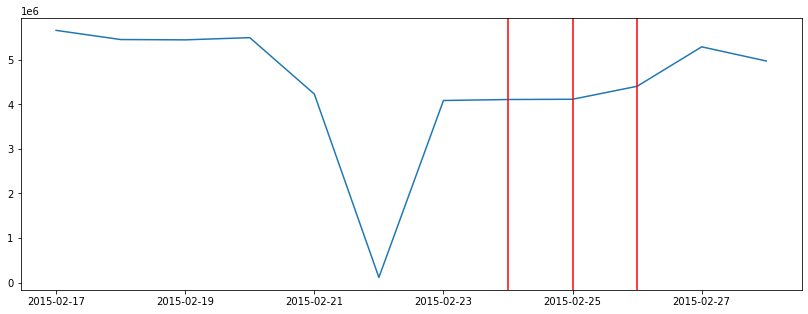

[MKChangePoint(start_time: 2015-02-24 00:00:00, end_time: 2015-02-24 00:00:00, confidence: 0.9973333182063859, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 MKChangePoint(start_time: 2015-02-25 00:00:00, end_time: 2015-02-25 00:00:00, confidence: 0.9973333182063859, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 MKChangePoint(start_time: 2015-02-26 00:00:00, end_time: 2015-02-26 00:00:00, confidence: 0.9973333182063859, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0)]

In [15]:
ts_sub_both_points = trend_mk_detect(kats_ts_sub, direction='both', window_size=7, freq=None,
                threshold=0.8, print_info='Down & Up Trend of ts subset')

ts_sub_both_points

## Seasonal M-K Test

* `pymannkendall` library (https://pypi.org/project/pymannkendall/) also includes modified M-K tests, such as Seasonal M-K test
* But Seasonal M-K only detect the trend within the same season, such as trend can be detected between 2013-01 and 2014-01, but not between 2013-01 and 2013-02
* Note: in this method, it's easy to get error if the window size isn't large enough

In [ ]:
def trend_smk_detect(ts, direction='both', window_size=20, period=12, threshold=0.8, print_info='Trend Detection'):
    print(print_info)
    ts_detector = SMKDetector(data=ts, threshold=threshold)
    detected_trend = ts_detector.detector(direction=direction, window_size=window_size, period=period, freq=None)  # `freq=None` means no seasonality
    ts_detector.plot(detected_trend)
    plt.show()
    
    return detected_trend

Down Trend of ts subset (SMK)


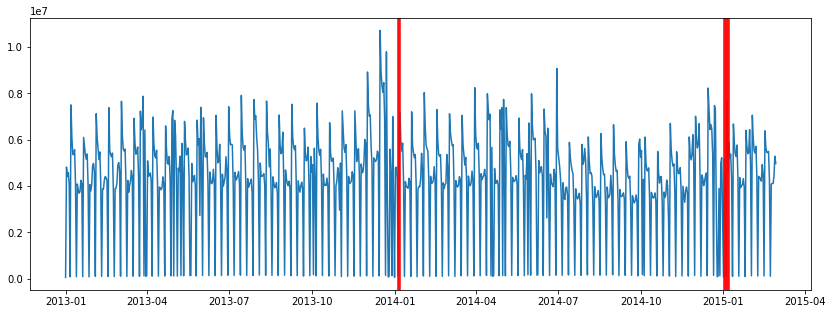

[SMKChangePoint(start_time: 2014-01-05 00:00:00, end_time: 2014-01-05 00:00:00, confidence: 0.9866716712191825, detector_type: <class 'Kats.kats.detectors.trend_smk.SMKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 SMKChangePoint(start_time: 2014-01-06 00:00:00, end_time: 2014-01-06 00:00:00, confidence: 0.9866716712191825, detector_type: <class 'Kats.kats.detectors.trend_smk.SMKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 SMKChangePoint(start_time: 2014-01-07 00:00:00, end_time: 2014-01-07 00:00:00, confidence: 0.9866716712191825, detector_type: <class 'Kats.kats.detectors.trend_smk.SMKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 SMKChangePoint(start_time: 2015-01-02 00:00:00, end_time: 2015-01-02 00:00:00, confidence: 0.9866716712191825, detector_type: <class 'Kats.kats.detectors.trend_smk.SMKDetector'>, is_multivariate: False, trend_direction: decreasing Tau: -1.0),
 SMKChangePoint(start_ti

In [8]:
smk_down_points = trend_smk_detect(kats_ts_all, direction='down', window_size=20, period=12,
                threshold=0.8, print_info='Down Trend of ts subset (SMK)')

smk_down_points